In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader as web
from scipy.stats import skew, kurtosis
import numpy as np
import datetime
import yfinance as yf
from IPython.display import display, Markdown

In [3]:
start = datetime.datetime(2014, 5, 31)
end = datetime.datetime(2024, 5, 31)

In [5]:
##Settore Tecnologico
aapl = yf.download('AAPL', start, end)
nvda = yf.download('NVDA', start, end)
##Settore Automobilistico
tsla = yf.download('TSLA', start, end)
gm = yf.download('GM', start, end)
##Settore Finanziario
jpm = yf.download('JPM', start, end)
wfc = yf.download('WFC', start, end)
##SP500
sp500 = yf.download('^GSPC', start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#I DataFrame originali presentano colonne multiIndici (Price e Ticker), il che possono essere un problema al momento di manipolare i dati per quanto
#riguardano i formati di ritorno. Quindi, rimuoviamo l'indice di colonna "Ticker" che non aggiunge informazione utile se non il nome dell'azione.
aapl = aapl.xs('AAPL', axis=1, level = 'Ticker', drop_level=True)
nvda = nvda.xs('NVDA', axis=1, level = 'Ticker', drop_level=True)
tsla = tsla.xs('TSLA', axis=1, level = 'Ticker', drop_level=True)
gm = gm.xs('GM', axis=1, level = 'Ticker', drop_level=True)
jpm = jpm.xs('JPM', axis=1, level = 'Ticker', drop_level=True)
wfc = wfc.xs('WFC', axis=1, level = 'Ticker', drop_level=True)
sp500 = sp500.xs('^GSPC', axis=1, level = 'Ticker', drop_level=True)

In [9]:
#Rimuoviamo le colonne che non ci interessano particolarmente per lo studio. Ci servono solo i prezzi di chiusura dai quali partiremmo con los studio
aapl = aapl.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
nvda = nvda.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
tsla = tsla.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
gm = gm.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
jpm = jpm.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
wfc = wfc.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)

In [37]:
# Creo un dizionario in cui tengo memorizzato il nome dell'azione originale e il nome della variabile corrispondente da me creata.
azioni = {
    'AAPL': aapl, 
    'NVDA': nvda,
    'TSLA': tsla, 
    'GM': gm,
    'JPM': jpm,
    'WFC': wfc
}
prezzi_chiusura_giornalieri_df = pd.concat({ticker: df['Close'] for ticker, df in azioni.items()}, axis=1)

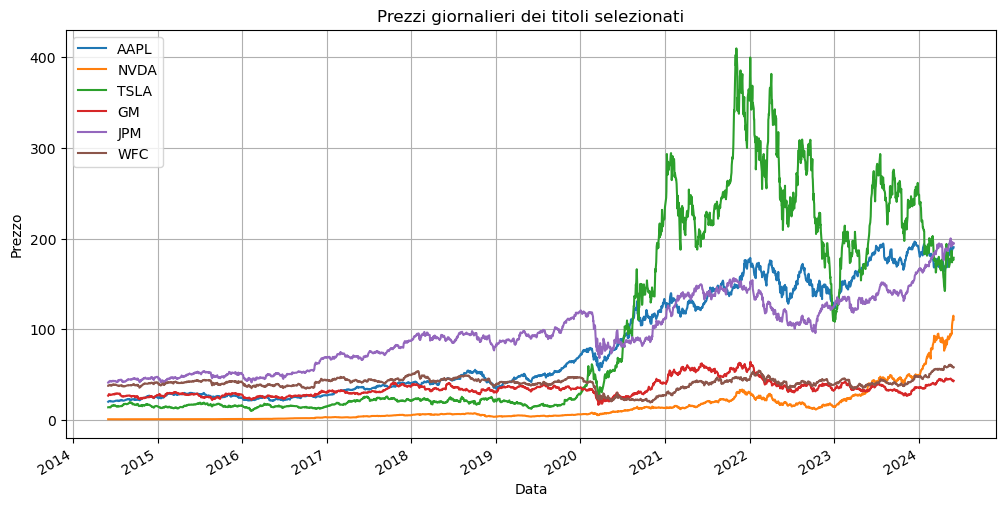

In [39]:
prezzi_chiusura_giornalieri_df.plot(figsize=(12,6))
plt.title("Prezzi giornalieri dei titoli selezionati")
plt.xlabel("Data")
plt.ylabel("Prezzo")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [17]:
#Calcolo del rendimenti semplici e rendimenti logaritmici GIORNALIERI
rit_semp_giornalieri = {}
rit_log_giornalieri = {}
for azione, value in azioni.items():
    rit_semp_giornalieri[azione] = value.pct_change().dropna()
    rit_log_giornalieri[azione] = np.log(value / value.shift(1)).dropna()

#Convertiamo il dizionario ritorni semplici/logaritmici giornalieri in dataframe per manipolarlo meglio
cleaned_rit_log = {azione: df['Close'] for azione, df in rit_log_giornalieri.items()}
cleaned_rit_semp = {azione: df['Close'] for azione, df in rit_semp_giornalieri.items()}
rit_log_giornalieri_df = pd.DataFrame(cleaned_rit_log)
rit_semp_giornalieri_df = pd.DataFrame(cleaned_rit_semp)

In [19]:
#Prezzi di chiusura mensili
prezzi_chiusura_mensili = {}
for azione, value in azioni.items():
    prezzi_chiusura_mensili[azione] = value.resample('ME').last()

cleaned_chiusura_mensili = {azione: df['Close'] for azione, df in prezzi_chiusura_mensili.items()}
prezzi_chiusura_mensili_df = pd.DataFrame(cleaned_chiusura_mensili)

In [21]:
#Calcolo del rendimenti semplici e rendimenti logaritmici MENSILI
rit_semp_mensili = {}
rit_log_mensili = {}
for azione, value in prezzi_chiusura_mensili.items():
    rit_semp_mensili[azione] = value.pct_change().dropna()
    rit_log_mensili[azione] = np.log(value / value.shift(1)).dropna()

#Convertiamo il dizionario ritorni semplici/logaritmici giornalieri in dataframe per manipolarlo meglio
cleaned_rit_log_mensili = {azione: df['Close'] for azione, df in rit_log_mensili.items()}
cleaned_rit_semp_mensili = {azione: df['Close'] for azione, df in rit_semp_mensili.items()}
rit_log_mensili_df = pd.DataFrame(cleaned_rit_log_mensili)
rit_semp_mensili_df = pd.DataFrame(cleaned_rit_semp_mensili)

In [23]:
#Calcolo del rendimento cumulato e rendimento composto annuo 
def calcola_rendimento_cumulato(df, colonna = 'Close'):
    prezzo_iniziale = df[colonna].iloc[0]
    prezzo_finale = df[colonna].iloc[-1]
    rendimento_cumulato = (prezzo_finale / prezzo_iniziale) - 1
    rendimento_cumulato_percentuale = rendimento_cumulato * 100
    return rendimento_cumulato_percentuale
    
for key, azione in azioni.items():
    rendimento = calcola_rendimento_cumulato(azione)
    print(f"{key}: {rendimento:.4f}%")

AAPL: 863.2213%
NVDA: 24413.0919%
TSLA: 1210.1367%
GM: 62.6196%
JPM: 375.6963%
WFC: 54.5285%


In [25]:
def calcola_rendimento_composto_annuo(df, colonna = 'Close'):
    prezzo_iniziale = df[colonna].iloc[0]
    prezzo_finale = df[colonna].iloc[-1]
    #Calcolo numero di anni (giorni_totali / 365)
    delta = end - start
    giorni_tot = delta.days
    anni = giorni_tot / 365.25 #Teniamo in considerazione gli anni bisestili (Ogni 4 anni ce n'e' uno in piu': +0.25)
    rendimento_composto_annuo = (prezzo_finale / prezzo_iniziale) ** (1 / anni) - 1
    return rendimento_composto_annuo

for key, azione in azioni.items():
    cagr = calcola_rendimento_composto_annuo(azione)
    print(f"{key}: {cagr:.4%}")

AAPL: 25.4178%
NVDA: 73.3433%
TSLA: 29.3351%
GM: 4.9819%
JPM: 16.8756%
WFC: 4.4476%


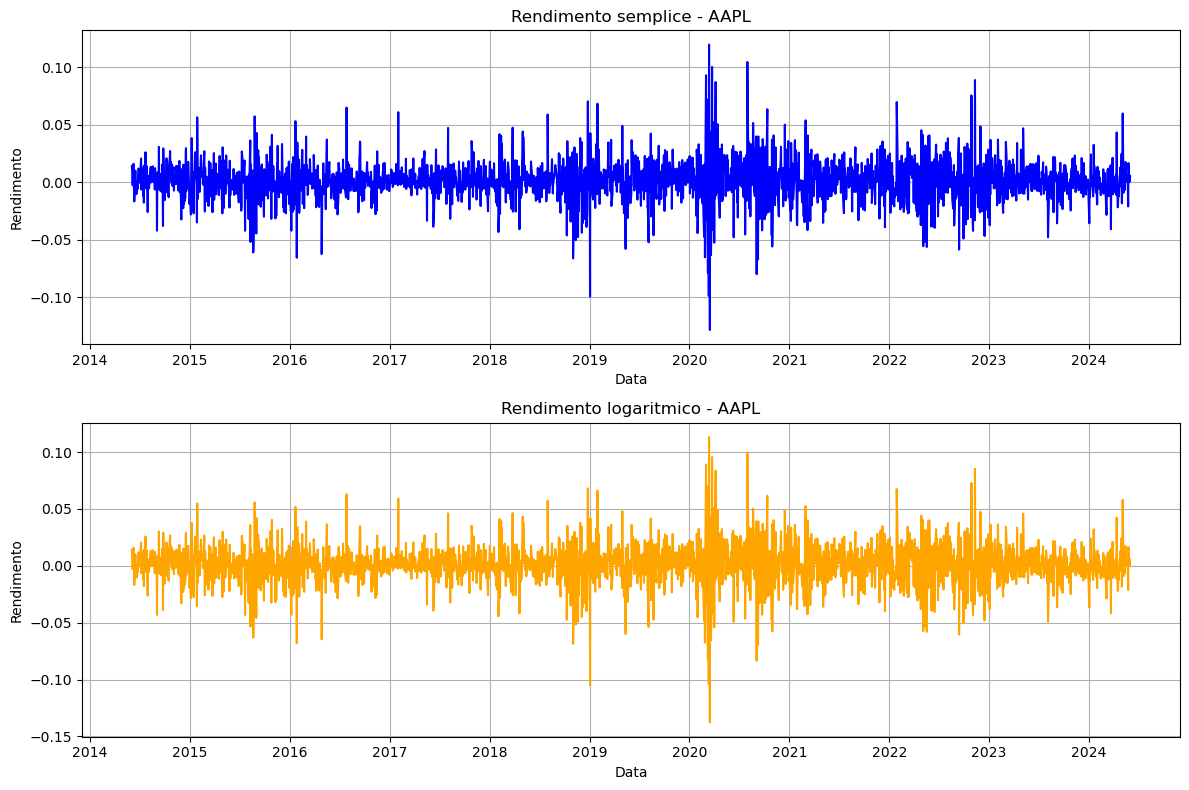

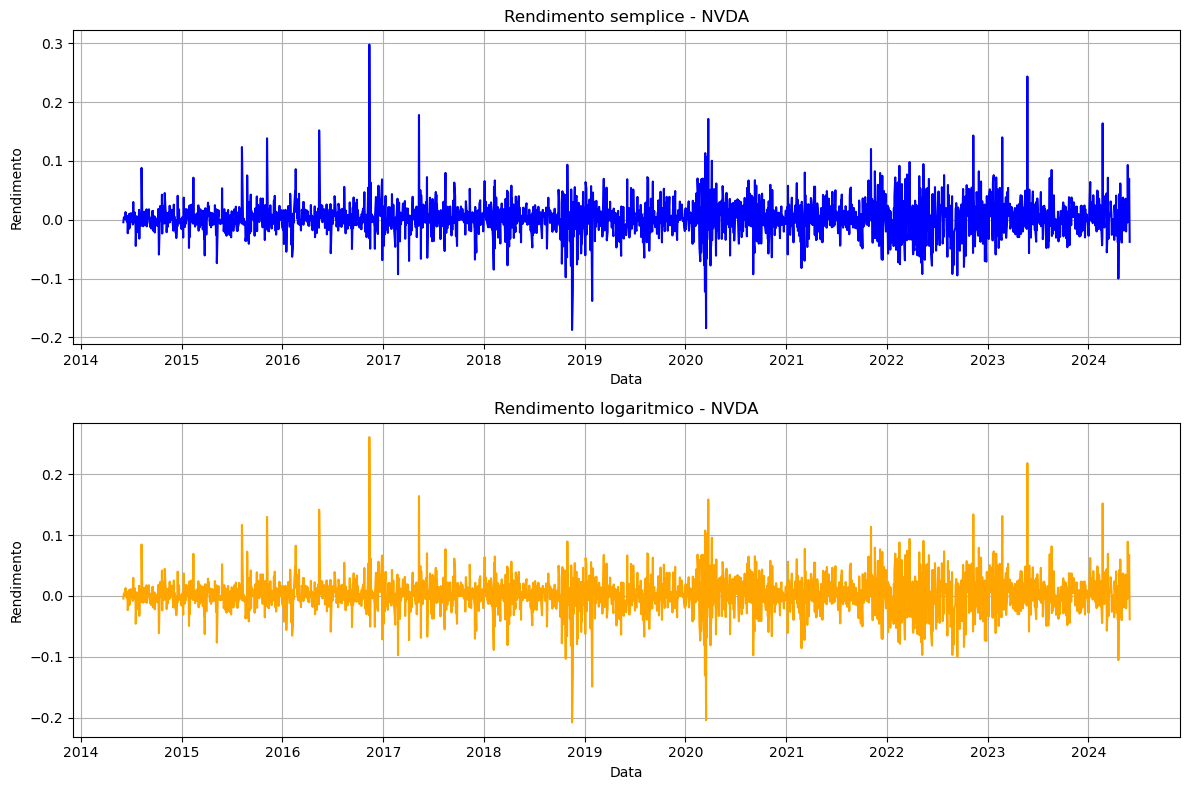

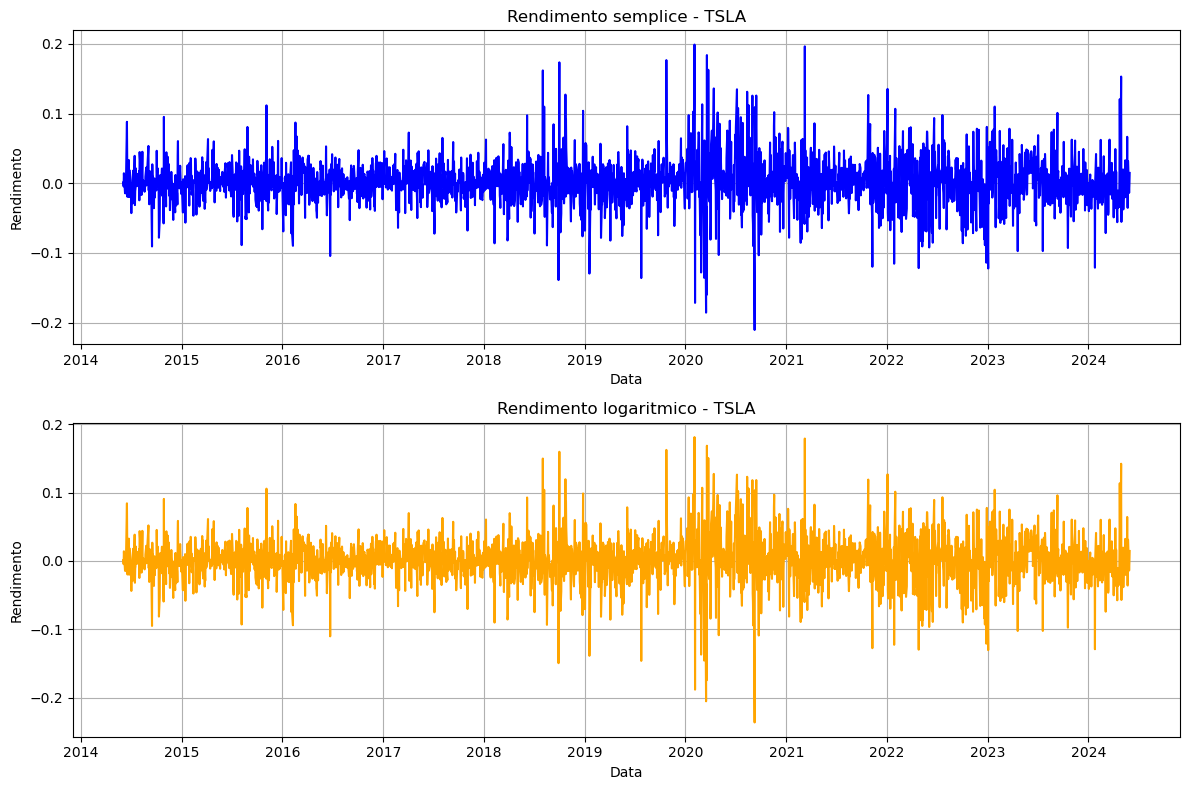

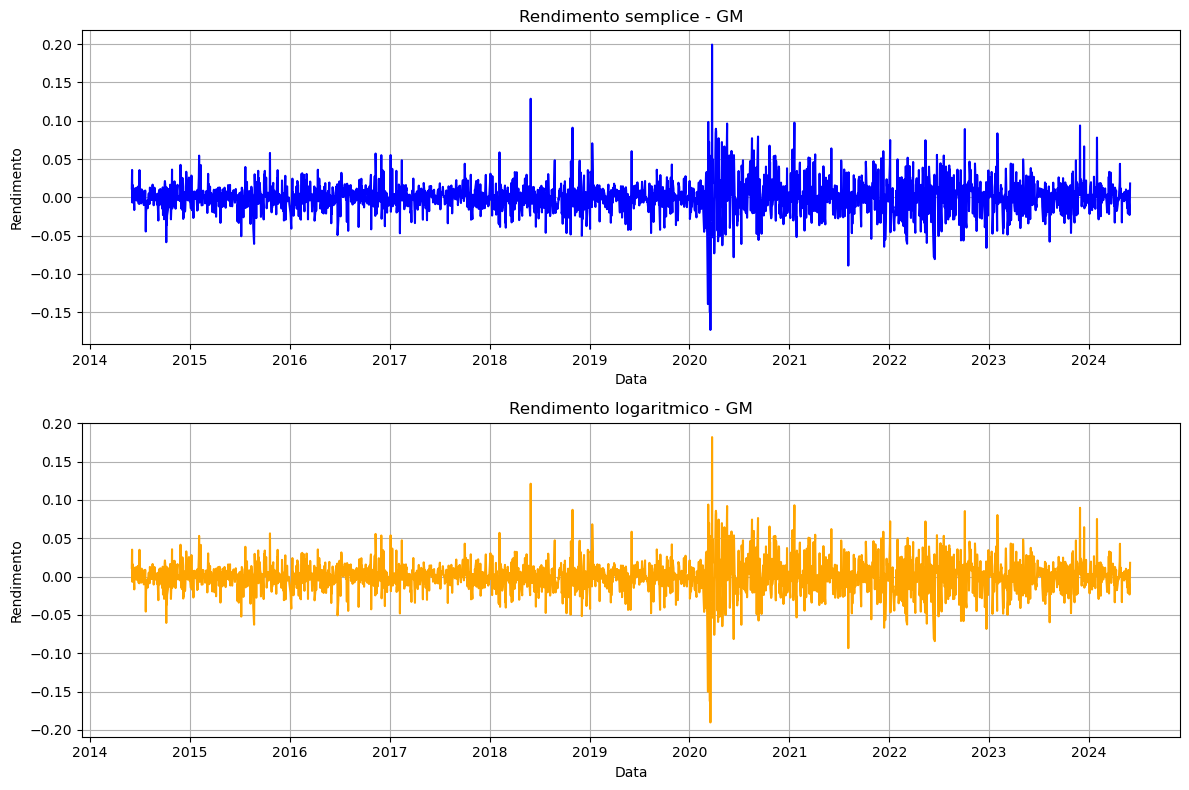

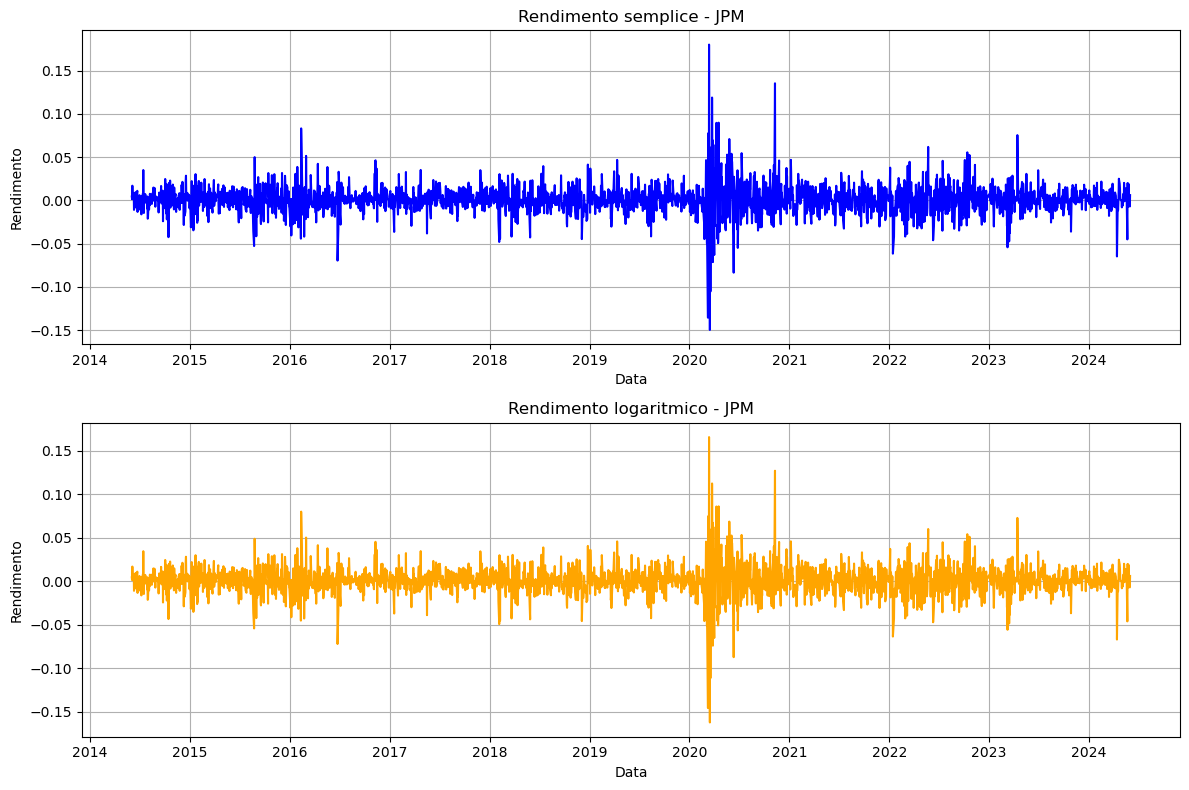

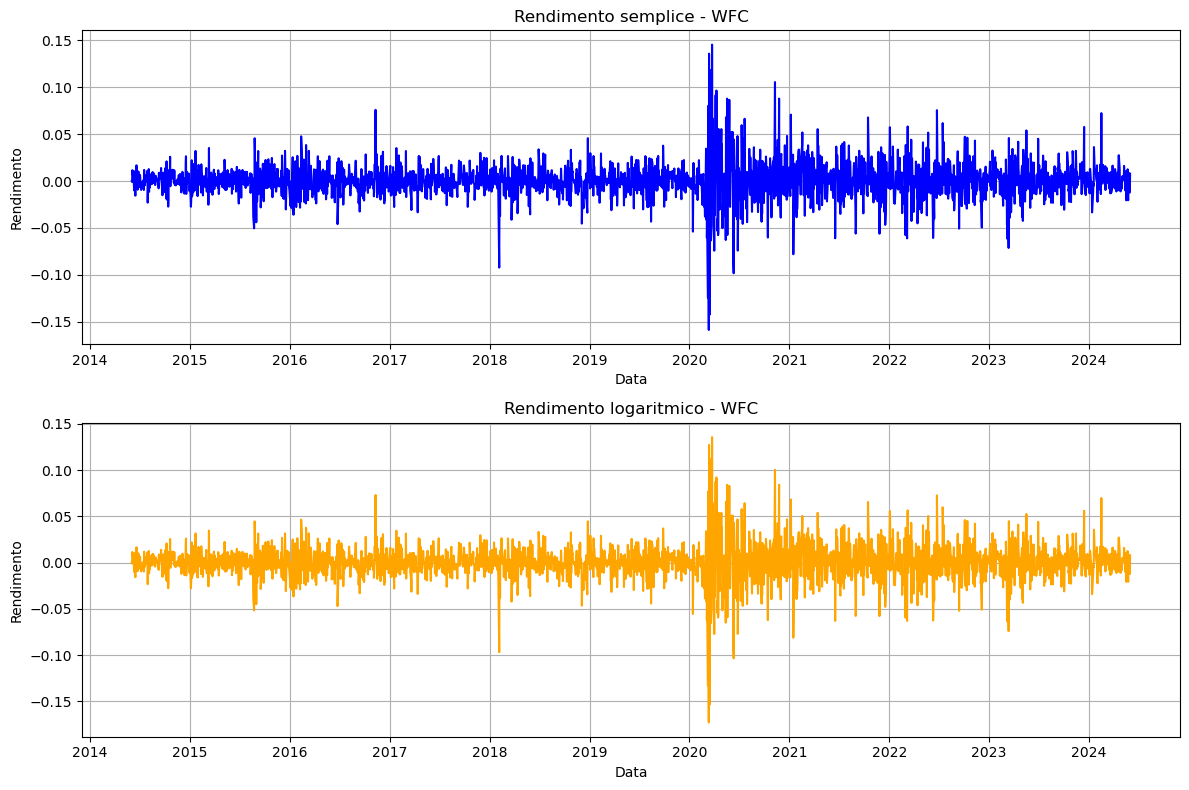

In [41]:
#Visualizzazione dei rendimenti semplici e logaritmici giornalieri 
for stock in azioni.keys():
    fig, axis = plt.subplots(2, 1, figsize = (12, 8))
    #Rendimento Semplice
    axis[0].plot(rit_semp_giornalieri[stock], color = "blue")
    axis[0].set_title(f"Rendimento semplice - {stock}")
    axis[0].set_ylabel("Rendimento")
    axis[0].set_xlabel("Data")
    axis[0].grid(True)
    #Rendimento Logaritmico
    axis[1].plot(rit_log_giornalieri[stock], color = "orange")
    axis[1].set_title(f"Rendimento logaritmico - {stock}")
    axis[1].set_ylabel("Rendimento")
    axis[1].set_xlabel("Data")
    axis[1].grid(True)
    plt.tight_layout()
    plt.show()

In [43]:
#Confrontiamo il rendimento fra societa' dello stesso settore
rit_log_tecnologia = pd.concat([rit_log_giornalieri['AAPL'], rit_log_giornalieri['NVDA']], axis = 1)
rit_log_automobili = pd.concat([rit_log_giornalieri['TSLA'], rit_log_giornalieri['GM']], axis = 1)
rit_log_banche = pd.concat([rit_log_giornalieri['JPM'], rit_log_giornalieri['WFC']], axis = 1)

rit_log_tecnologia.columns = ["AAPL", "NVDA"]
rit_log_automobili.columns = ["TSLA", "GM"]
rit_log_banche.columns = ["JPM", "WFC"]

In [53]:
display(Markdown("### Ritorni logaritmici tecnologia"))
display(rit_log_tecnologia)

display(Markdown("### Ritorni logaritmici automobili"))
display(rit_log_automobili)

display(Markdown("### Ritorni logaritmici banche"))
display(rit_log_banche)

### Ritorni logaritmici tecnologia

,AAPL,NVDA
Date,,
2014-06-03,0.014042,-0.004233
2014-06-04,0.011354,0.001059
2014-06-05,0.003916,0.004229
2014-06-06,-0.002753,0.003685
2014-06-09,0.015874,0.001050
...,...,...
2024-05-23,-0.021283,0.089106
2024-05-24,0.016452,0.025398
2024-05-28,0.000053,0.067476


### Ritorni logaritmici automobili

,TSLA,GM
Date,,
2014-06-03,0.001172,0.011409
2014-06-04,-0.004646,0.035111
2014-06-05,0.014165,-0.006869
2014-06-06,0.006120,0.015996
2014-06-09,-0.013834,-0.001369
...,...,...
2024-05-23,-0.036008,-0.005473
2024-05-24,0.031166,0.008652
2024-05-28,-0.013989,-0.023396


### Ritorni logaritmici banche

,JPM,WFC
Date,,
2014-06-03,0.004506,0.000000
2014-06-04,0.001438,-0.000979
2014-06-05,0.016918,0.011493
2014-06-06,0.005986,0.006756
2014-06-09,0.007868,0.010145
...,...,...
2024-05-23,-0.007034,-0.020729
2024-05-24,0.019064,0.008841
2024-05-28,-0.006047,-0.012198


In [55]:
correlazione_tecnologia = rit_log_tecnologia.corr()
correlazione_automobili = rit_log_automobili.corr()
rit_log_banche = rit_log_banche.corr()

In [57]:
display(Markdown("### Correlazione settore Tecnologico"))
display(correlazione_tecnologia)

display(Markdown("### Correlazione settore Automobilistico"))
display(correlazione_automobili)

display(Markdown("### Correlazione settore Bancario"))
display(rit_log_banche)

### Correlazione settore Tecnologico

,AAPL,NVDA
AAPL,1.000000,0.551793
NVDA,0.551793,1.000000


### Correlazione settore Automobilistico

,TSLA,GM
TSLA,1.000000,0.334649
GM,0.334649,1.000000


### Correlazione settore Bancario

,JPM,WFC
JPM,1.000000,0.811769
WFC,0.811769,1.000000


In [59]:
## Grafici Diagnostici a 3 sezioni (Istogrammi + Kernel Density, Boxplot, QQ-Plot)

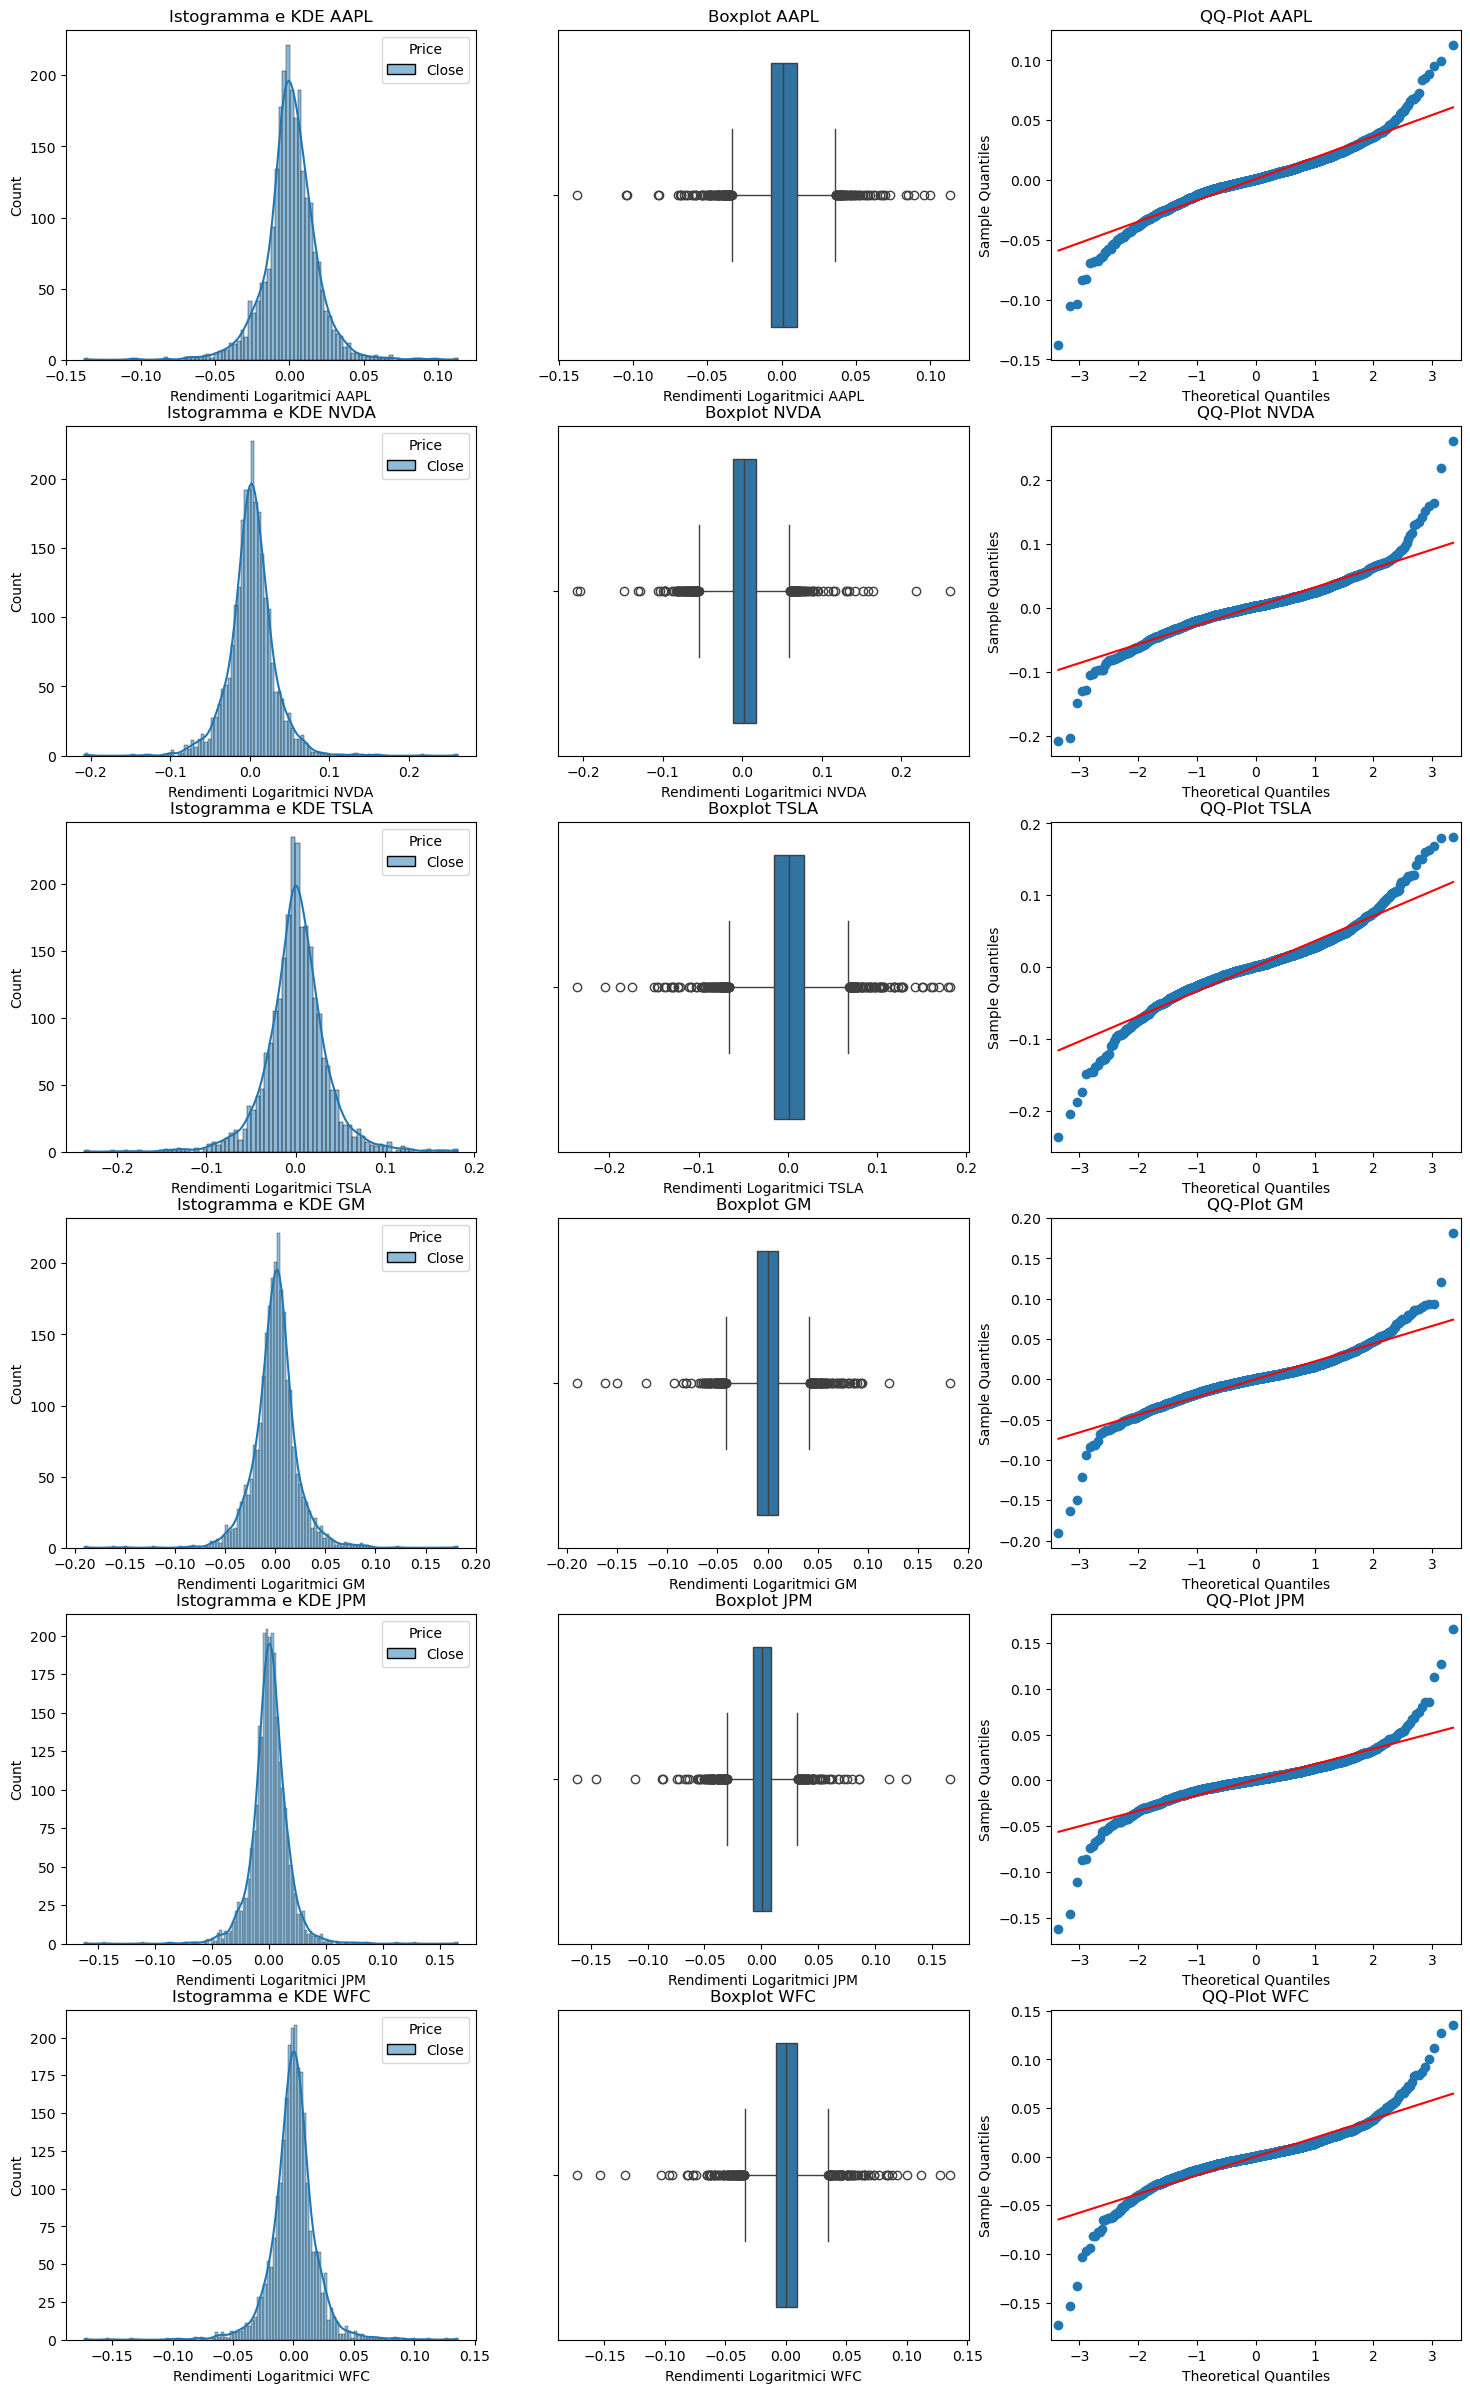

In [61]:
fig, axes = plt.subplots(6, 3, figsize = (18, 30))

for i, (stock, data) in enumerate(rit_log_giornalieri.items()):
    #Istogramma + KDE
    sns.histplot(data = data, kde = True, ax = axes[i, 0])
    axes[i, 0].set_title(f"Istogramma e KDE {stock}")
    axes[i, 0].set_xlabel(f"Rendimenti Logaritmici {stock}")
    #Boxplot
    sns.boxplot(x = data['Close'], ax = axes[i, 1])
    axes[i, 1].set_title(f"Boxplot {stock}")
    axes[i, 1].set_xlabel(f"Rendimenti Logaritmici {stock}")
    #QQ-Plot
    sm.qqplot(data['Close'], line = 's', ax = axes[i, 2])
    axes[i, 2].set_title(f"QQ-Plot {stock}")

In [65]:
##Statistiche Descrittive Univariate Anualizzate 

#Creiamo una lista per raccogliere i risultati per ogni serie di rendimenti 
statistiche_riassunto = []

for stock, data in cleaned_rit_log_mensili.items():
    mean_ann = data.mean() * 12
    var_ann = data.var() * 12
    std_ann = data.std() * np.sqrt(12)
    skewness = data.skew()
    kurt = data.kurtosis()
    #Aggiungiamo tutto in una lista
    statistiche_riassunto.append({
        'Azione': stock,
        'Media Annuale': mean_ann,
        'Varianza Annuale': var_ann,
        'Deviazione Std Annuale': std_ann,
        'Asimmetria': skewness,
        'Curtosi': kurt
    })

# Ora creiamo il DataFrame riassuntivo
riassunto_df = pd.DataFrame(statistiche_riassunto)

In [67]:
riassunto_df

,Azione,Media Annuale,Varianza Annuale,Deviazione Std Annuale,Asimmetria,Curtosi
0,AAPL,0.224968,0.075843,0.275396,-0.233385,-0.437557
1,NVDA,0.556955,0.209159,0.457339,-0.508200,0.625071
2,TSLA,0.243365,0.322536,0.567923,0.436901,0.784186
3,GM,0.044114,0.110113,0.331833,-0.302397,1.272176
4,JPM,0.153218,0.058423,0.241709,-0.482866,1.475211
5,WFC,0.041026,0.081551,0.285571,-0.703083,2.825326


In [69]:
#Ora, calcoliamo le matrici di varianze/covarianze e correlazioni:
matrice_covarianza = rit_log_mensili_df.cov()
matrice_covarianza

,AAPL,NVDA,TSLA,GM,JPM,WFC
AAPL,0.006320,0.005925,0.006770,0.003060,0.001700,0.001657
NVDA,0.005925,0.017430,0.007570,0.005196,0.003318,0.002951
TSLA,0.006770,0.007570,0.026878,0.005904,0.002515,0.003525
GM,0.003060,0.005196,0.005904,0.009176,0.004452,0.004877
JPM,0.001700,0.003318,0.002515,0.004452,0.004869,0.004589
WFC,0.001657,0.002951,0.003525,0.004877,0.004589,0.006796


In [71]:
matrice_correlazione = rit_log_mensili_df.corr()
matrice_correlazione

,AAPL,NVDA,TSLA,GM,JPM,WFC
AAPL,1.000000,0.564509,0.519401,0.401867,0.306515,0.252882
NVDA,0.564509,1.000000,0.349754,0.410871,0.360173,0.271105
TSLA,0.519401,0.349754,1.000000,0.375922,0.219841,0.260850
GM,0.401867,0.410871,0.375922,1.000000,0.666097,0.617567
JPM,0.306515,0.360173,0.219841,0.666097,1.000000,0.797769
WFC,0.252882,0.271105,0.260850,0.617567,0.797769,1.000000


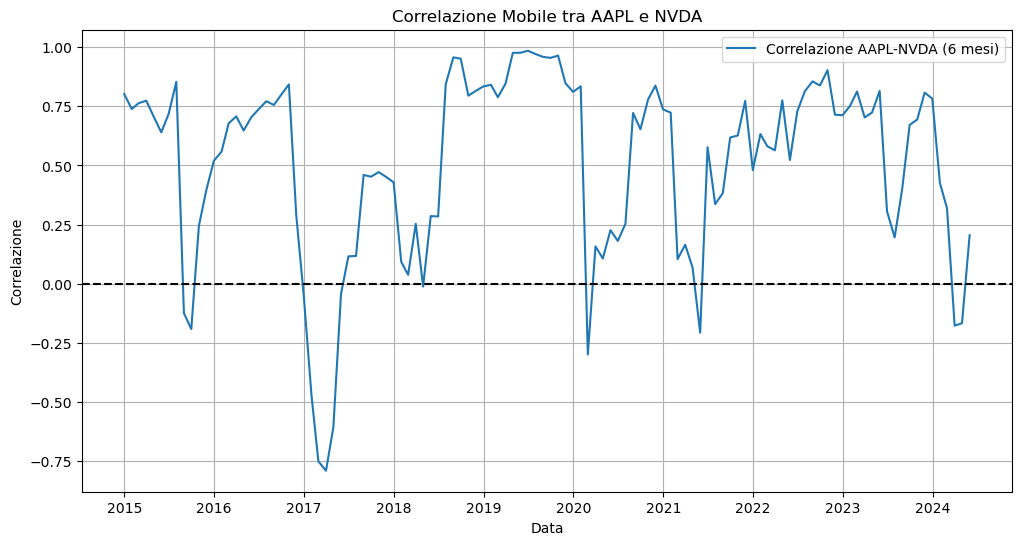

In [73]:
correlazione_temporale = rit_log_mensili_df['AAPL'].rolling(window = 6).corr(rit_log_mensili_df['NVDA'])
plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale, label = 'Correlazione AAPL-NVDA (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile tra AAPL e NVDA')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

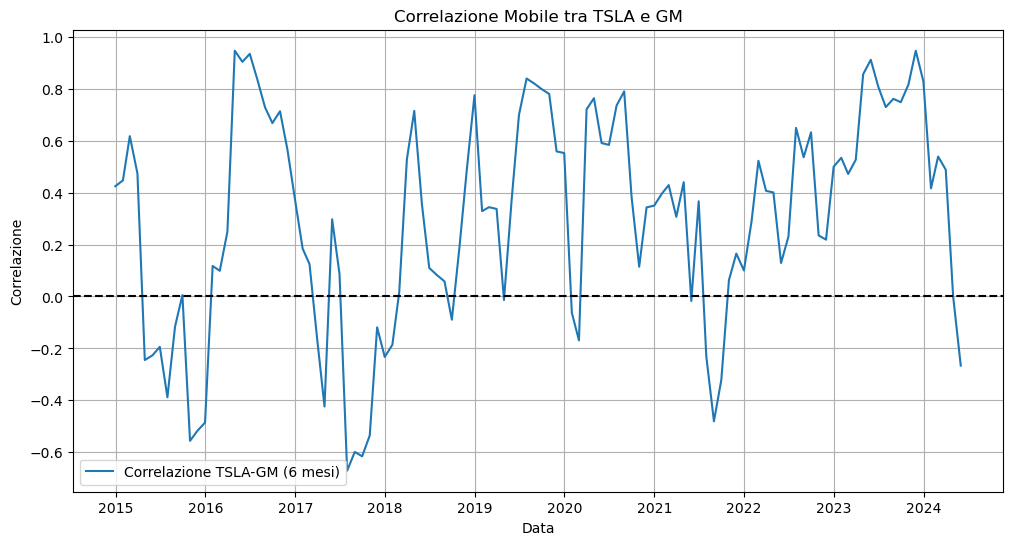

In [75]:
correlazione_temporale = rit_log_mensili_df['TSLA'].rolling(window = 6).corr(rit_log_mensili_df['GM'])
plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale, label = 'Correlazione TSLA-GM (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile tra TSLA e GM')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

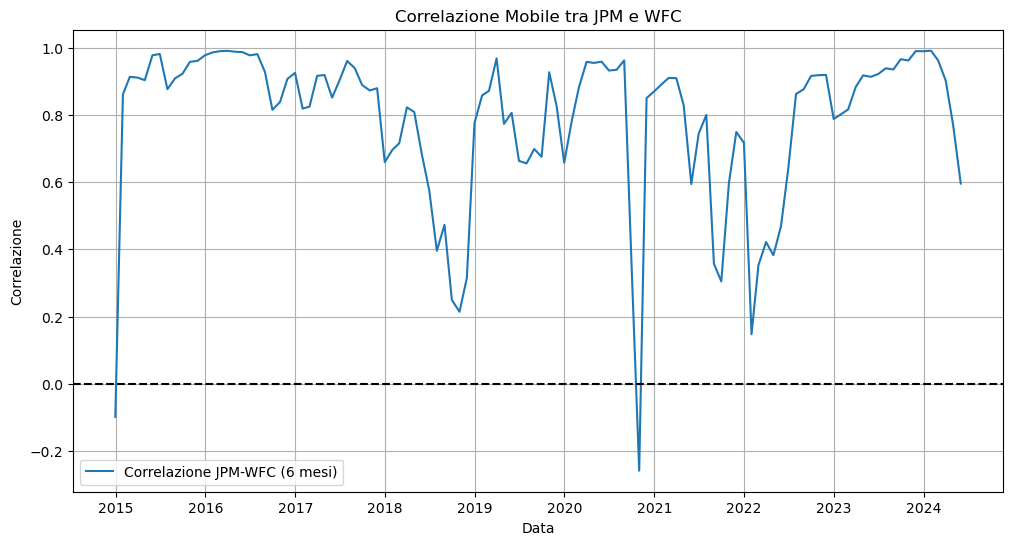

In [77]:
correlazione_temporale = rit_log_mensili_df['JPM'].rolling(window = 6).corr(rit_log_mensili_df['WFC'])
plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale, label = 'Correlazione JPM-WFC (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile tra JPM e WFC')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

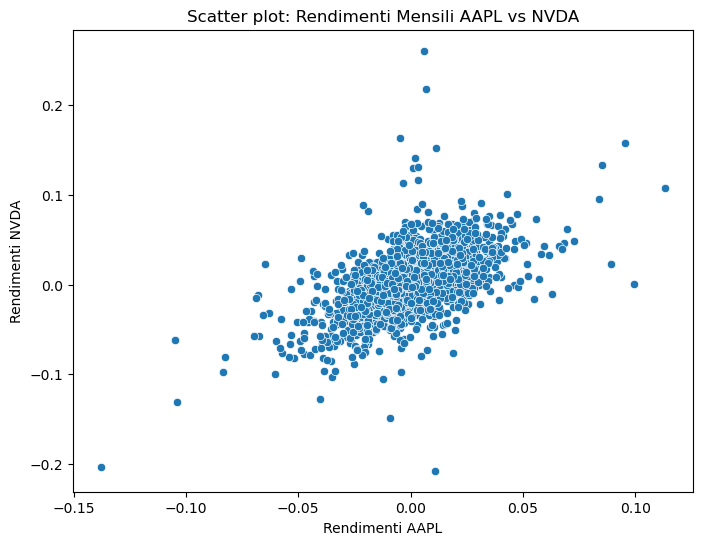

In [79]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['AAPL'], y = rit_log_giornalieri_df['NVDA'])
plt.title('Scatter plot: Rendimenti Mensili AAPL vs NVDA')
plt.xlabel('Rendimenti AAPL')
plt.ylabel('Rendimenti NVDA')
plt.show()

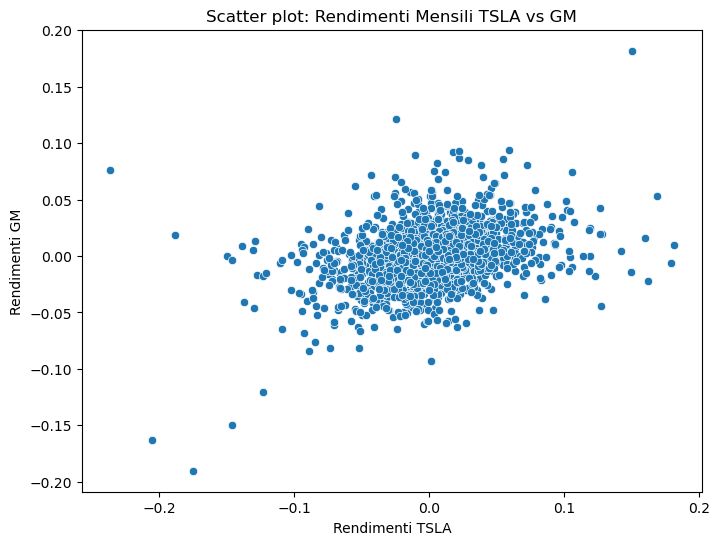

In [81]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['TSLA'], y = rit_log_giornalieri_df['GM'])
plt.title('Scatter plot: Rendimenti Mensili TSLA vs GM')
plt.xlabel('Rendimenti TSLA')
plt.ylabel('Rendimenti GM')
plt.show()

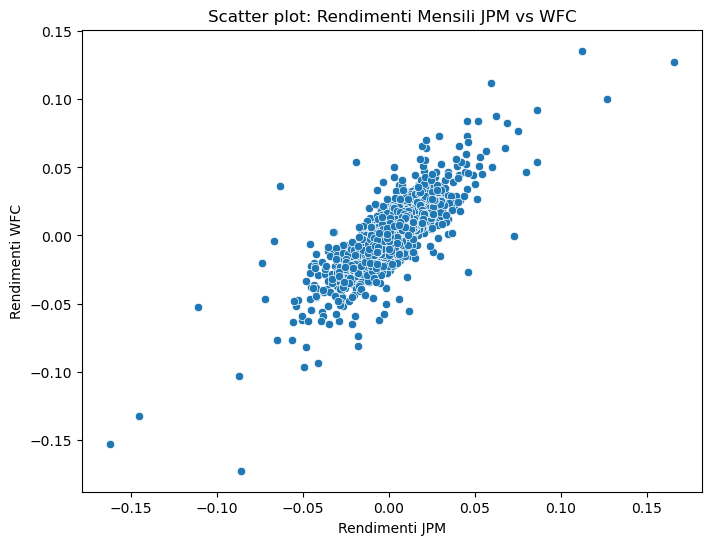

In [83]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['JPM'], y = rit_log_giornalieri_df['WFC'])
plt.title('Scatter plot: Rendimenti Mensili JPM vs WFC')
plt.xlabel('Rendimenti JPM')
plt.ylabel('Rendimenti WFC')
plt.show()

In [85]:
#3. Analisi di Previsione 
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Parametri
n = 80 #mesi
m = 30 #mesi
l = 10 #mesi

In [ ]:
for rendimento_logaritmico_mensile in rit_log_mensili_df.values():
    trainset = rendimento_logaritmico_mensile[:n]
    testset = rendimento_logaritmico_mensile[n:n + m]
    forecast_target = rendimento_logaritmico_mensile[n + m: n + m + l]
    #Verificare la stagionalita' tramite adfuller 
    result = adfuller(trainset)
    print('p-value:', result[1])
    #Trovare la migliore configurazione di ARIMA con autoarima
    model = auto_arima(ts,
                   seasonal=True,        # False se non c'è stagionalità
                   trace=True,        
                   #error_action='ignore', 
                   suppress_warnings=True,
                   stepwise=True)
    #model-fit
    model_fit = model.fit()
    #testset
    forecast_30 = model_fit.forecast(steps=m)
    #Ultimi 10 mesi 
    forecast_10 = forecast_30[-l:]
    #Valori reali
    actual_10 = forecast_target
    #Errori RMSE e MAE
    mae = mean_absolute_error(actual_10, forecast_10)
    rmse = np.sqrt(mean_squared_error(actual_10, forecast_10))
    print(f"MAE previsione ultimi 10 mesi: {mae:.6f}")
    print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}")
    #Mostrare il grafico 
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_target.index, actual_10, label='Reale', marker='o')
    plt.plot(forecast_target.index, forecast_10, label='Previsione', marker='x')
    plt.title("Previsioni vs Valori Reali")
    plt.legend()
    plt.grid(True)
    plt.show()
    #

In [164]:
ts = rit_log_mensili_df['AAPL']

In [166]:
ts

Date
2014-07-31    0.028326
2014-08-31    0.074652
2014-09-30   -0.017220
2014-10-31    0.069489
2014-11-30    0.100731
                ...   
2024-01-31   -0.043145
2024-02-29   -0.018717
2024-03-31   -0.052648
2024-04-30   -0.006729
2024-05-31    0.117408
Freq: ME, Name: AAPL, Length: 119, dtype: float64

In [186]:
trainset = ts[:n]
testset = ts[n:n + m]
forecast_target = ts[n + m - 1: n + m + l]

In [188]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(trainset)
print('p-value:', result[1])

p-value: 1.2593244747376439e-12


In [190]:
model = auto_arima(ts,
                   seasonal=False,        # False se non c'è stagionalità
                   trace=True,            # mostra i risultati provati
                   #error_action='ignore', 
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-252.696, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-257.419, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-256.128, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-256.363, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-261.912, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.007, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-260.057, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-259.736, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.953 seconds


In [192]:
model = ARIMA(trainset, order=(0, 0, 0))
model_fit = model.fit()

In [194]:
forecast_30 = model_fit.forecast(steps=m)

In [196]:
forecast_30

2021-03-31    0.02195
2021-04-30    0.02195
2021-05-31    0.02195
2021-06-30    0.02195
2021-07-31    0.02195
2021-08-31    0.02195
2021-09-30    0.02195
2021-10-31    0.02195
2021-11-30    0.02195
2021-12-31    0.02195
2022-01-31    0.02195
2022-02-28    0.02195
2022-03-31    0.02195
2022-04-30    0.02195
2022-05-31    0.02195
2022-06-30    0.02195
2022-07-31    0.02195
2022-08-31    0.02195
2022-09-30    0.02195
2022-10-31    0.02195
2022-11-30    0.02195
2022-12-31    0.02195
2023-01-31    0.02195
2023-02-28    0.02195
2023-03-31    0.02195
2023-04-30    0.02195
2023-05-31    0.02195
2023-06-30    0.02195
2023-07-31    0.02195
2023-08-31    0.02195
Freq: ME, Name: predicted_mean, dtype: float64

In [198]:
forecast_10 = forecast_30[-l:]
actual_10 = forecast_target

In [200]:
actual_10

Date
2023-08-31   -0.043308
2023-09-30   -0.092859
2023-10-31   -0.002573
2023-11-30    0.107760
2023-12-31    0.013491
2024-01-31   -0.043145
2024-02-29   -0.018717
2024-03-31   -0.052648
2024-04-30   -0.006729
2024-05-31    0.117408
Freq: ME, Name: AAPL, dtype: float64

In [202]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(actual_10, forecast_10)
rmse = np.sqrt(mean_squared_error(actual_10, forecast_10))
print(f"MAE previsione ultimi 10 mesi: {mae:.6f}")
print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}")

MAE previsione ultimi 10 mesi: 0.060336
MAE: 0.060336, RMSE: 0.068460


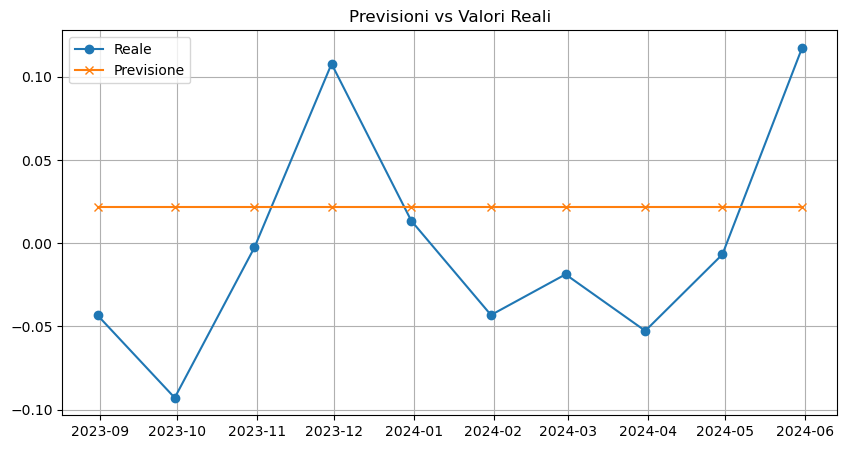

In [204]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_target.index, actual_10, label='Reale', marker='o')
plt.plot(forecast_target.index, forecast_10, label='Previsione', marker='x')
plt.title("Previsioni vs Valori Reali")
plt.legend()
plt.grid(True)
plt.show()

In [198]:
#Ora bisogna ricostruire i prezzi futuri

In [206]:
actual_10

Date
2023-08-31   -0.043308
2023-09-30   -0.092859
2023-10-31   -0.002573
2023-11-30    0.107760
2023-12-31    0.013491
2024-01-31   -0.043145
2024-02-29   -0.018717
2024-03-31   -0.052648
2024-04-30   -0.006729
2024-05-31    0.117408
Freq: ME, Name: AAPL, dtype: float64

In [208]:
forecast_10

2022-11-30    0.02195
2022-12-31    0.02195
2023-01-31    0.02195
2023-02-28    0.02195
2023-03-31    0.02195
2023-04-30    0.02195
2023-05-31    0.02195
2023-06-30    0.02195
2023-07-31    0.02195
2023-08-31    0.02195
Freq: ME, Name: predicted_mean, dtype: float64

In [210]:
forecast_30

2021-03-31    0.02195
2021-04-30    0.02195
2021-05-31    0.02195
2021-06-30    0.02195
2021-07-31    0.02195
2021-08-31    0.02195
2021-09-30    0.02195
2021-10-31    0.02195
2021-11-30    0.02195
2021-12-31    0.02195
2022-01-31    0.02195
2022-02-28    0.02195
2022-03-31    0.02195
2022-04-30    0.02195
2022-05-31    0.02195
2022-06-30    0.02195
2022-07-31    0.02195
2022-08-31    0.02195
2022-09-30    0.02195
2022-10-31    0.02195
2022-11-30    0.02195
2022-12-31    0.02195
2023-01-31    0.02195
2023-02-28    0.02195
2023-03-31    0.02195
2023-04-30    0.02195
2023-05-31    0.02195
2023-06-30    0.02195
2023-07-31    0.02195
2023-08-31    0.02195
Freq: ME, Name: predicted_mean, dtype: float64

In [224]:
# Ricostruzione dei livelli di prezzo
prezzo_iniziale = prezzi_chiusura_mensili_df['AAPL'].loc['2022-11-30']
prezzi_previsione = [prezzo_iniziale]
for r in forecast_10.values:
    next_price = prezzi_previsione[-1] * np.exp(r)
    prezzi_previsione.append(next_price)

prezzi_previsione = prezzi_previsione[1:]  # escludi il primo che è last_price

In [226]:
prezzi_previsione

[149.38022286175902,
 152.69542955422685,
 156.08421088196584,
 159.5481996924747,
 163.08906507116126,
 166.70851314557328,
 170.4082879074775,
 174.19017205318306,
 178.05598784251447,
 182.00759797684762]

In [230]:
prezzi_reali_mensili = prezzi_chiusura_mensili_df['AAPL'].loc['2023-08-31': '2024-05-31']
prezzi_reali_mensili

Date
2023-08-31    186.258820
2023-09-30    169.741699
2023-10-31    169.305481
2023-11-30    188.569092
2023-12-31    191.130325
2024-01-31    183.059418
2024-02-29    179.664948
2024-03-31    170.450577
2024-04-30    169.307495
2024-05-31    190.399567
Freq: ME, Name: AAPL, dtype: float64

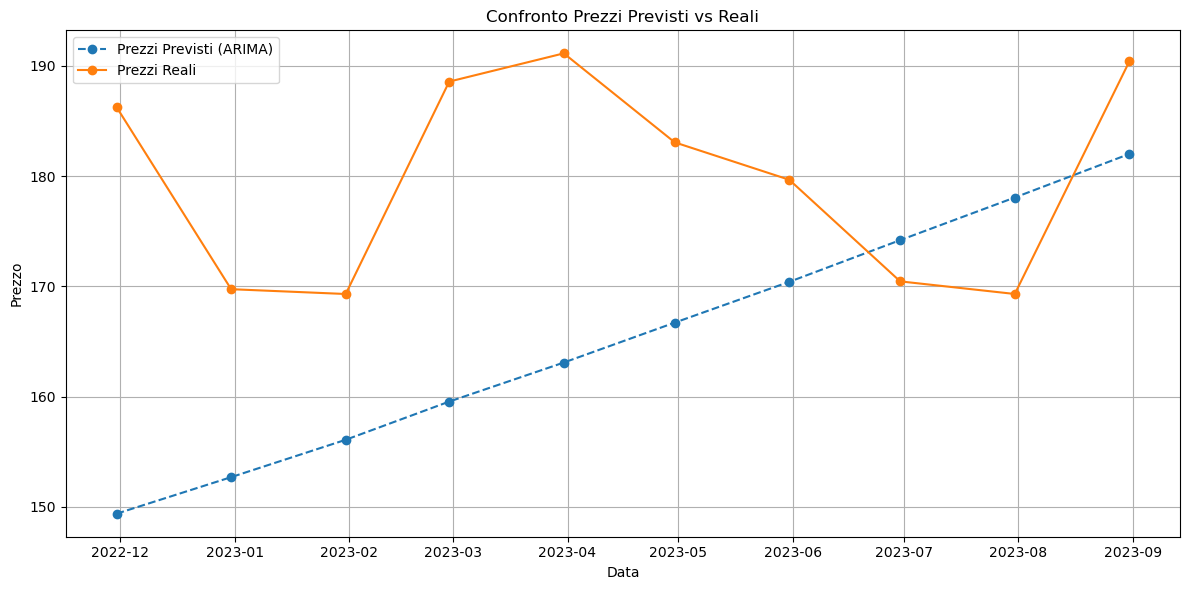

In [232]:
dates = forecast_10.index

plt.figure(figsize=(12, 6))
plt.plot(dates, prezzi_previsione, label='Prezzi Previsti (ARIMA)', linestyle='--', marker='o')
plt.plot(dates, prezzi_reali_mensili, label='Prezzi Reali', linestyle='-', marker='o')

plt.title('Confronto Prezzi Previsti vs Reali')
plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.legend()
plt.grid(True)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [234]:
mae = mean_absolute_error(prezzi_reali_mensili, prezzi_previsione)
rmse = np.sqrt(mean_squared_error(prezzi_reali_mensili, prezzi_previsione))
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

MAE (Mean Absolute Error): 17.07
RMSE (Root Mean Squared Error): 19.92


In [236]:
#MAE = 17.07 --> In media, i prezzi previsti si discostano dai reali di circa 17.07 dollari. significa un errore medio del 9%-10%

In [452]:
#Strategie di trading e backtesting - Analisi tecnica

In [23]:
aapl['Return'] = aapl['Close'].pct_change(1)
results = []
sharpe_buyhold = aapl['Return'].mean() / aapl['Return'].std() * np.sqrt(252)
for short in range(10, 101, 10):
    for long in range(50, 301, 10):
        if short >= long:
            continue

        aapl['MA_short'] = aapl['Close'].rolling(window=short).mean()
        aapl['MA_long'] = aapl['Close'].rolling(window=long).mean()

        aapl['Signal'] = 0
        aapl.loc[aapl['MA_short'] > aapl['MA_long'], 'Signal'] = 1
        aapl.loc[aapl['MA_short'] < aapl['MA_long'], 'Signal'] = -1  

        aapl['Strategy_Return'] = aapl['Signal'].shift(1) * aapl['Return']
        
        sharpe_strategy = aapl['Strategy_Return'].mean() / aapl['Strategy_Return'].std() * np.sqrt(252)
        results.append({
            'short': short,
            'long': long,
            'sharpe': sharpe_strategy
        })

In [25]:
results

[{'short': 10, 'long': 50, 'sharpe': 0.2571210007281037},
 {'short': 10, 'long': 60, 'sharpe': 0.3079977142072628},
 {'short': 10, 'long': 70, 'sharpe': 0.2704445462572812},
 {'short': 10, 'long': 80, 'sharpe': 0.3041897629573719},
 {'short': 10, 'long': 90, 'sharpe': 0.15055806708380257},
 {'short': 10, 'long': 100, 'sharpe': -0.00574683602749026},
 {'short': 10, 'long': 110, 'sharpe': 0.042672526282085635},
 {'short': 10, 'long': 120, 'sharpe': 0.04581781284867014},
 {'short': 10, 'long': 130, 'sharpe': 0.05091187348587504},
 {'short': 10, 'long': 140, 'sharpe': 0.16783354273941206},
 {'short': 10, 'long': 150, 'sharpe': 0.19879168267725103},
 {'short': 10, 'long': 160, 'sharpe': 0.17790950788490206},
 {'short': 10, 'long': 170, 'sharpe': 0.2332467097452201},
 {'short': 10, 'long': 180, 'sharpe': 0.2998733090338757},
 {'short': 10, 'long': 190, 'sharpe': 0.4579274863076359},
 {'short': 10, 'long': 200, 'sharpe': 0.519146085184506},
 {'short': 10, 'long': 210, 'sharpe': 0.562937619941

In [27]:
best_result = max(results, key=lambda x: x['sharpe'])
best_result

{'short': 100, 'long': 300, 'sharpe': 0.6696779898079214}

In [29]:
sharpe_buyhold

0.9430262081472259

In [508]:
#Strategia scelta: Crossover delle medie mobili 

#Media mobile breve (100gg) e lungo (300gg)
aapl['SMA_100'] = aapl['Close'].rolling(window = 100).mean()
aapl['SMA_300'] = aapl['Close'].rolling(window = 300).mean()
#Crea segnali 
aapl['Signal'] = 0
aapl.loc[aapl['SMA_100'] > aapl['SMA_300'], 'Signal'] = 1
aapl.loc[aapl['SMA_100'] < aapl['SMA_300'], 'Signal'] = -1
# Calcola rendimento strategia
aapl['Return'] = aapl['Close'].pct_change(1)
aapl['Strategy_Return'] = aapl['Signal'].shift(1) * aapl['Return']
# Valore cumulato
aapl['Strategy_Value'] = (1 + aapl['Strategy_Return']).cumprod()
aapl['Buy_Hold_Value'] = (1 + aapl['Return']).cumprod()

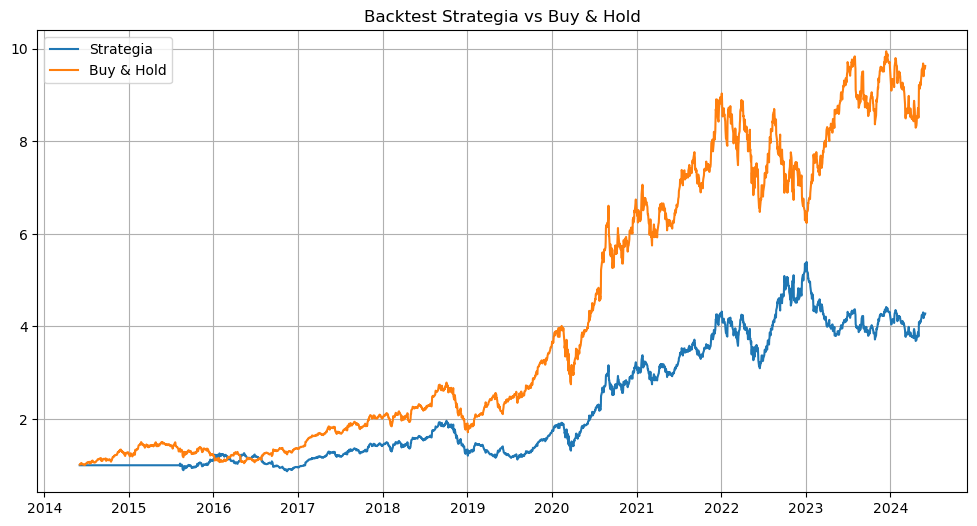

In [510]:
plt.figure(figsize=(12,6))
plt.plot(aapl['Strategy_Value'], label='Strategia')
plt.plot(aapl['Buy_Hold_Value'], label='Buy & Hold')
plt.legend()
plt.title('Backtest Strategia vs Buy & Hold')
plt.grid(True)
plt.show()

In [516]:
##CAPM

In [35]:
#Per questa sezione dobbiamo usare i prezzi di chiusura mensili e i rendimenti semplici mensili 
#Per stimare Beta e Alpha nel Capital Asset Pricing Model (CAPM) bisogna applicare una regressione lineare
#Regressione lineare --> (Ri - Rf) = alpha + Beta(Rm - Rf) + eps
#(Ri - Rf) = y --> Rendimento in eccesso dell'azione 
#(Rm - Rf) = X --> Rendimento in eccesso del mercato
#Rf --> Tasso privo di Risk-Free 
#Ri --> Rendimento dell'azione 
#Rm --> Rendimento del mercato 

In [65]:
#Secondo il tasso T-Bill USA 1 anno e' 4.11% annuale che dobbiamo dividere in 12 mesi --> 0.3425%
risk_free = 0.003425

In [67]:
#Per il rendimento atteso del mercato possiamo prendere la media storica negli ultimi decenni dell'indice SP500 pari al 8% annuo divisi in 12 mesi --> 0.6667%
market_return = 0.006667

In [63]:
rit_semp_mensili_df

,AAPL,MSFT,TSLA,FORD,XOM,NEE
Date,,,,,,
2014-07-31,0.028731,0.035012,-0.069816,0.114754,-0.017283,-0.083822
2014-08-31,0.077509,0.059169,0.207792,-0.058824,0.012259,0.056487
2014-09-30,-0.017073,0.020471,-0.100185,0.039062,-0.054394,-0.046419
2014-10-31,0.071960,0.012727,-0.004038,-0.082707,0.028283,0.067533
2014-11-30,0.105978,0.024740,0.011667,-0.098361,-0.057040,0.048976
...,...,...,...,...,...,...
2024-01-31,-0.042227,0.057281,-0.246257,-0.013699,0.028306,-0.034738
2024-02-29,-0.018543,0.042318,0.077901,-0.097222,0.026081,-0.050057
2024-03-31,-0.051286,0.017116,-0.129235,-0.061538,0.112131,0.158000


In [83]:
#Calcolo del rendimento in eccesso di SP500
sp500 = sp500.drop(['Open','High','Low','Volume'], axis = 1)
sp500_mensile = sp500.resample('ME').last()
sp500_rit_semp_mensile = sp500_mensile['Close'].pct_change().dropna()
rendimento_eccesso_mercato = sp500_rit_semp_mensile - risk_free
#Calcolo del rendimento in eccesso dell'azione
rentimento_eccesso_azione = {}
for key, value in rit_semp_mensili.items():
    rentimento_eccesso_azione[key] = value - risk_free

#X e y della regressione lineare
X = rendimento_eccesso_mercato
X1 = sm.add_constant(X)
#Dizionari per salvare i valori beta e alpha 
valori_beta = {}
valori_alpha = {}
for key, value in rentimento_eccesso_azione.items():
    y = value
    model = sm.OLS(y,X1)
    results = model.fit()
    intercept, beta = results.params
    #Salva i risultati
    valori_alpha[key] = intercept
    valori_beta[key] = beta

# Crea un DataFrame riassuntivo
risultati_beta_alpha = pd.DataFrame({
    'Alpha': valori_alpha,
    'Beta': valori_beta
})
risultati_beta_alpha

,Alpha,Beta
AAPL,0.011450,1.237935
MSFT,0.013560,0.989734
TSLA,0.020428,1.827549
FORD,-0.000296,0.364562
XOM,-0.001199,0.944012
NEE,0.007201,0.456629


In [573]:
#Calcolare il rendimento atteso con CAPM 
#La formula CAPM e' --> Rendimento_atteso = Rf + Beta(R_mercato - Rf), dove Rf e' Risk-Free (tipicamente il rendimento di un T-Bill a 1 anno)

In [89]:
#Rendimento atteso azioni con la formula CAPM
for azione, beta in valori_beta.items():
    rendimento_atteso_mensile = risk_free + beta*(market_return - risk_free)
    rendimento_atteso_annuale = (rendimento_atteso_mensile * 12) * 100
    print(f"Rendimento atteso annuo {azione}: {rendimento_atteso_annuale:.3f}%")

Rendimento atteso annuo AAPL: 8.926%
Rendimento atteso annuo MSFT: 7.960%
Rendimento atteso annuo TSLA: 11.220%
Rendimento atteso annuo FORD: 5.528%
Rendimento atteso annuo XOM: 7.783%
Rendimento atteso annuo NEE: 5.886%


In [91]:
#Calcolo esposizione di ogni titolo ai fattori di rischio Fama-French
import getFamaFrenchFactors as gff

In [ ]:
#L'obiettivo e' stimare il modello Fama-French a 3 fattori
#Formula --> (Ri - Rf) = alpha + B1(Rm - Rf) + B2(SMB) + B3(HML) + Eps
#B1, B2 e B3: Esposizione del titolo a ciascun fattore

In [97]:
ff3_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_mensile

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1,1926-08-31,0.0264,-0.0114,0.0381,0.0025
2,1926-09-30,0.0038,-0.0136,0.0005,0.0023
3,1926-10-31,-0.0327,-0.0014,0.0082,0.0032
4,1926-11-30,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...,...
1180,2024-11-30,0.0649,0.0446,0.0016,0.0040
1181,2024-12-31,-0.0317,-0.0271,-0.0299,0.0037
1182,2025-01-31,0.0280,-0.0197,0.0163,0.0037
1183,2025-02-28,-0.0244,-0.0579,0.0491,0.0033


In [99]:
#Cambio nome della colonna "date_ff_factors" a "Data"
ff3_mensile.rename({'date_ff_factors': 'Data'}, axis=1, inplace=True)
#Impostiamo le date come indice del dataframe
ff3_mensile.set_index('Data', inplace = True)
ff3_mensile.head()

,Mkt-RF,SMB,HML,RF
Data,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023
1926-10-31,-0.0327,-0.0014,0.0082,0.0032
1926-11-30,0.0254,-0.0011,-0.0061,0.0031


In [103]:
#Dizionario per salvare i risultati
ff_risultati = {}
for azione, rendimenti in rit_semp_mensili.items():
    # Unisce con i Fama-French factors
    data = pd.concat([rit_semp_mensili_df[azione], ff3_mensile], axis = 1, join = 'inner')
    # Calcola rendimento in eccesso
    data['excess_ret'] = data[azione] - data['RF']
    # Regressori: Mkt-RF, SMB, HML
    X = data[['Mkt-RF', 'SMB', 'HML']]
    X1 = sm.add_constant(X)
    y = data['excess_ret']
    # Modello OLS
    model = sm.OLS(y, X1).fit()
    # Salva i risultati in un dizionario
    ff_risultati[azione] = {
        'alpha': model.params['const'],
        'beta_mkt': model.params['Mkt-RF'],
        'beta_smb': model.params['SMB'],
        'beta_hml': model.params['HML'],
        'r_squared': model.rsquared
    }

In [105]:
ff_risultati_df = pd.DataFrame(ff_risultati).T
ff_risultati_df

,alpha,beta_mkt,beta_smb,beta_hml,r_squared
AAPL,0.007670,1.240373,-0.214190,-0.567018,0.534990
MSFT,0.009689,1.051288,-0.685923,-0.398772,0.605834
TSLA,0.015776,1.752172,0.752151,-1.089840,0.292920
FORD,0.004694,0.192545,1.664997,-0.148176,0.071462
XOM,0.000343,0.877199,0.064638,1.031702,0.523387
NEE,0.006231,0.490559,-0.360284,-0.326096,0.178006


In [169]:
# Modello Fama-French a 5 fattori estende il modello a 3 fattori aggiungendo altri 2 fattori legati alla redditivita' e agli investimenti

In [27]:
ff5_mensile = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start, end = end)[0]
ff5_mensile.index = ff5_mensile.index.to_timestamp('M')
ff5_mensile

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_6476\3009102139.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_mensile = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start, end = end)[0]
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_6476\3009102139.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_mensile = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start, end = end)[0]


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2014-05-31,2.04,-1.86,-0.10,-0.09,-0.96,0.00
2014-06-30,2.61,3.06,-0.71,-1.83,-1.91,0.00
2014-07-31,-2.03,-4.20,-0.08,0.93,0.51,0.00
2014-08-31,4.24,0.29,-0.57,-0.64,-0.69,0.00
2014-09-30,-1.96,-3.66,-1.47,1.20,-0.59,0.00
...,...,...,...,...,...,...
2024-01-31,0.73,-5.71,-2.38,0.69,-0.96,0.47
2024-02-29,5.07,-0.78,-3.43,-1.94,-2.14,0.42
2024-03-31,2.84,-1.19,4.16,1.46,1.14,0.43


In [31]:
#Dizionario per salvare i risultati
ff5_risultati = {}
for azione, rendimenti in rit_semp_mensili.items():
    # Unisce con i Fama-French factors
    data = pd.concat([rit_semp_mensili_df[azione], ff5_mensile], axis = 1, join = 'inner')
    # Calcola rendimento in eccesso
    data['excess_ret'] = data[azione] - data['RF']
    # Regressori: Mkt-RF, SMB, HML
    X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X1 = sm.add_constant(X)
    y = data['excess_ret']
    # Modello OLS
    model = sm.OLS(y, X1).fit()
    # Salva i risultati in un dizionario
    ff5_risultati[azione] = {
        'alpha': model.params['const'],
        'beta_mkt': model.params['Mkt-RF'],
        'beta_smb': model.params['SMB'],
        'beta_hml': model.params['HML'],
        'beta_rmw': model.params['RMW'],
        'beta_cma': model.params['CMA'],
        'r_squared': model.rsquared
    }

In [33]:
ff5_risultati_df = pd.DataFrame(ff5_risultati).T
ff5_risultati_df

,alpha,beta_mkt,beta_smb,beta_hml,beta_rmw,beta_cma,r_squared
AAPL,-0.108901,0.011922,0.008581,-0.010265,0.008796,0.012035,0.141360
MSFT,-0.104551,0.010519,0.000686,-0.005367,0.001437,0.009475,0.090996
TSLA,-0.097060,0.017654,0.011131,-0.012274,-0.003606,0.006098,0.162757
FORD,-0.107521,0.003962,0.019844,-0.010702,-0.010628,0.022335,0.090706
XOM,-0.114827,0.009333,0.010420,0.002926,0.002371,0.019159,0.208519
NEE,-0.109830,0.004986,0.006811,-0.008847,0.006064,0.015725,0.053597


In [107]:
#Strategie di trading e backtesting – Strategie dinamiche

In [125]:
#Simuliamo, innanzitutto, la strategia CPPI sui titoli in portafoglio
#La CPPI protegge il capitale investito garantendo che il valore del portafoglio non scenda sotto un certo livello minimo (floor), e investe l'eccesso in asset rischiosi.
#All'inizio imposteremmo i pesi dei titoli in modo equo, cioe, che abbiano lo stesso peso (Equal Weigth)
#Formula --> Exposure = m x (Portfolio_Value - Floor)
# Portfolio_value - Floor --> Cushion
# m --> Moltiplicatore 

In [161]:
equal_weights = np.repeat(1/6, 6) #Pesi iniziali equi
investimento_iniziale = 100000
floor_value = 0.6 * investimento_iniziale #Protezione del capitale all'80%
moltiplicatore = 5 #A seconda del rischio che vogliamo affrontare sopra la soglia minima garantita: Piu' basso minore rischio, piu' alto maggiore rischio e maggiori rendimenti potenziali  

In [163]:
#Simulazione CPPI
cppi_risultati = []
valore_portafoglio = investimento_iniziale
account_value = investimento_iniziale

In [165]:
for date, ritorno in rit_semp_giornalieri_df.iterrows():
    cushion = max(portfolio_value - floor_value, 0)
    exposure = moltiplicatore * cushion
    risky_weight = min(exposure / valore_portafoglio, 1)
    safe_weight = 1 - risky_weight
    
    portfolio_ret = (risky_weight * np.dot(equal_weights, ritorno)) + (safe_weight * 0)
    valore_portafoglio *= (1 + portfolio_ret)
    cppi_risultati.append({'Date': date, 'Portfolio Value': valore_portafoglio, 'Risky Weight': risky_weight})

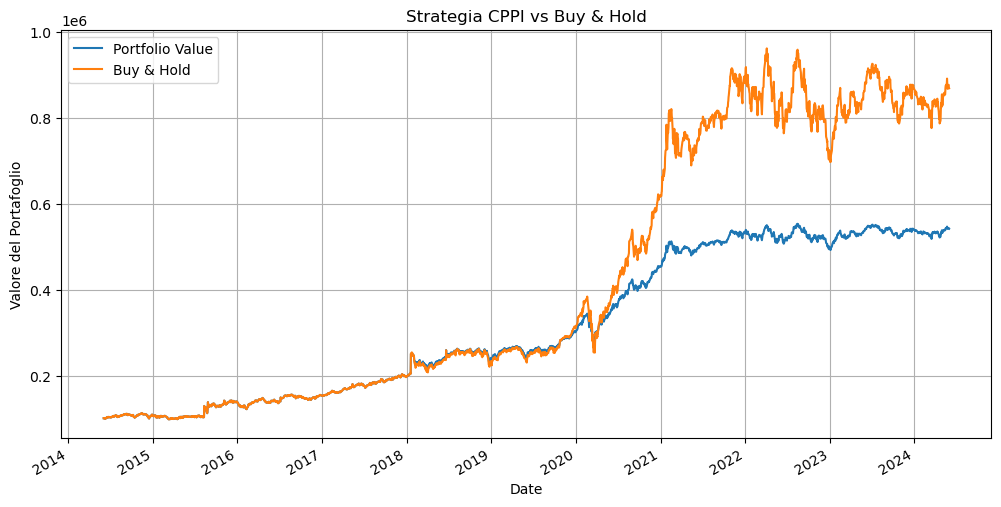

In [167]:
cppi_df = pd.DataFrame(cppi_risultati).set_index('Date')
cppi_df['Buy & Hold'] = (1 + rit_semp_giornalieri_df.dot(equal_weights)).cumprod() * investimento_iniziale

cppi_df[['Portfolio Value', 'Buy & Hold']].plot(figsize=(12,6), title="Strategia CPPI vs Buy & Hold")
plt.ylabel("Valore del Portafoglio")
plt.grid(True)
plt.show()

In [ ]:
#Moltiplicatore(m) --> 